In [1]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [3]:
# Load off the training and testing images
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
len(train_images), len(test_images)

(1250, 250)

In [4]:
# tf.strings returns byte-strings
train_ds = tf.data.Dataset.list_files(str('imagenet-5-categories/train/*.jpg'), seed=666)
for f in train_ds.take(5):
    print(f.numpy())

b'imagenet-5-categories/train/elephant_1393028287_487e3bf3ba.jpg'
b'imagenet-5-categories/train/car_2663384793_2608e05f88.jpg'
b'imagenet-5-categories/train/airplane_2110882407_db1564e294.jpg'
b'imagenet-5-categories/train/cat_103392464_9743e196fb.jpg'
b'imagenet-5-categories/train/cat_1112640457_401418ec93.jpg'


In [5]:
# Build a lookup table
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant([b'car', b'dog', b'elephant', b'cat', b'airplane']),
        values=tf.constant([0, 1, 2, 3, 4]),
    ),
    default_value=tf.constant(-1),
)

# now let us do a lookup
input_tensor = tf.constant([b'car', b'dog', b'airplane', b'cat', b'elephant'])
out = table.lookup(input_tensor)
print(out)

tf.Tensor([0 1 4 3 2], shape=(5,), dtype=int32)


In [6]:
# Image preprocessing utils
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])
    
    label = tf.strings.split(tf.strings.split(image_path, "/")[2], "_")[0]
    
    label = table.lookup(label)
    
    return image, label

In [18]:
# Prepare TensorFlow datasets

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .repeat()
    .batch(64)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices(test_images)
test_ds = (
    test_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .repeat()
    .batch(64)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [19]:
# Verification utils
LABELS = ["car", "dog", "elephant", "cat", "airplane"]

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(LABELS[label_batch[n].numpy()].title())
        plt.axis('off')

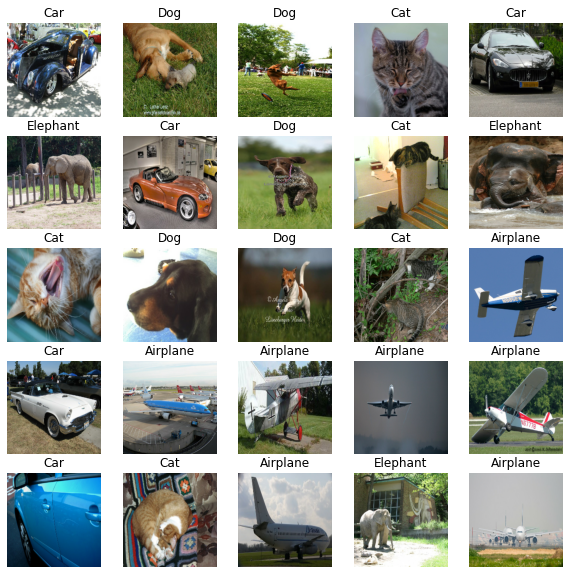

In [20]:
# Verify train images
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

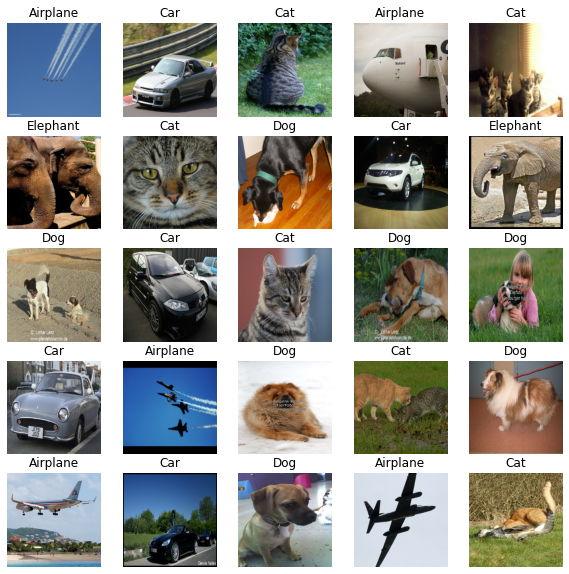

In [21]:
# Verify test images
image_batch, label_batch = next(iter(test_ds))
show_batch(image_batch, label_batch)

In [22]:
# Architecture utils
def get_training_model():
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)
    output = Dense(5, activation="softmax")(h)

    classifier = Model(inputs, output)

    return classifier

In [25]:
# Initialize and compile the model
model = get_training_model()
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
             optimizer="sgd")

In [26]:
# Train the model
model.fit(train_ds,
    steps_per_epoch=len(train_images)//64,
    validation_data=test_ds,
    validation_steps=len(test_images)//64,
    epochs=20)

Train for 19 steps, validate for 3 steps
Epoch 1/20
19/19 [==============================] - 20s 1s/step - loss: 2.7598 - accuracy: 0.2393 - val_loss: 2.5084 - val_accuracy: 0.2500
Epoch 2/20
19/19 [==============================] - 13s 698ms/step - loss: 1.9616 - accuracy: 0.3067 - val_loss: 2.3274 - val_accuracy: 0.3906
Epoch 3/20
19/19 [==============================] - 14s 715ms/step - loss: 1.6575 - accuracy: 0.3947 - val_loss: 1.8711 - val_accuracy: 0.3906
Epoch 4/20
19/19 [==============================] - 13s 695ms/step - loss: 1.6013 - accuracy: 0.4062 - val_loss: 1.4726 - val_accuracy: 0.3802
Epoch 5/20
19/19 [==============================] - 13s 683ms/step - loss: 1.5892 - accuracy: 0.4260 - val_loss: 1.5944 - val_accuracy: 0.4375
Epoch 6/20
19/19 [==============================] - 13s 680ms/step - loss: 1.3354 - accuracy: 0.4819 - val_loss: 1.4578 - val_accuracy: 0.4792
Epoch 7/20
19/19 [==============================] - 13s 683ms/step - loss: 1.2619 - accuracy: 0.4868 - v